<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/blob/stacking/3.model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
from google.colab import drive
import pickle
import os

In [2]:
# PEP 8
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

# Import module files

In [3]:
%%capture
git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Kaggle.Restaurant-Revenue-Prediction/main/'

files = [
    'sklearn_utils.py',
    'sklearn_transformers.py',
    'model.py',
    'path_manager.py'
]

def download_files(dict_):
    for file, url in dict_.items():
        !wget -O {file} {url} {file}
    
download_files(
    {
        file: git_download_path + file for file in files
    }
)

In [4]:
import importlib
import sklearn_transformers
import sklearn_utils 
import path_manager
import model

def reload_all(list_):
    for module in list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils,
        sklearn_transformers,
        model
    ]
)

from model import Model
from path_manager import PathManager
from sklearn_utils import dict_subset

# Setup paths

In [13]:
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'

COMPETITION_PATH = gdrive_path + 'ML/Competitions/5.RestaurantRevenue/'
PREPROC_TRIAL = 4
MODELS_TRIAL = 'Stacking'

pep8(_ih)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



In [14]:
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)

pep8(_ih)

# Download models

In [15]:
models = manager.load_models()

In [16]:
models

{'Stacking reg': StackingRegressor(estimators=[('RF',
                                RandomForestRegressor(max_depth=1,
                                                      max_features='sqrt',
                                                      n_estimators=2,
                                                      random_state=42)),
                               ('ElasticNet',
                                ElasticNet(alpha=0.05, l1_ratio=0.2,
                                           random_state=42)),
                               ('XGB',
                                GradientBoostingRegressor(max_features='sqrt',
                                                          n_estimators=3,
                                                          random_state=42,
                                                          subsample=0.5))],
                   final_estimator=RandomForestRegressor(max_depth=1,
                                                         n_estimators=3

In [ ]:
models = dict_subset(
    models,
    [
        'Extra trees_gs',
        'ElasticNet_gs',
        'RF_gs',
        'SVM reg_gs',
        'XGB_gs',
        'Voting reg'
    ]
)

# Download data

In [17]:
df_test = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_processed.csv'
    ),
    index_col=[0]
)

# subsample from train.csv for testing
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    ),
    index_col=[0]
)

df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_sample_processed.csv'
    ),
    index_col=[0]
)

X_train_val = df_trainval.values[:, :-1]
Y_train_val = df_trainval.values[:, -1]

X_test_sample = df_test_sample.values[:, :-1]
Y_test_sample = df_test_sample.values[:, -1]

# Model mistake analysis

- From feature importance analysis, we see that the most important features are **opening year** and **city population**

# Feature importance

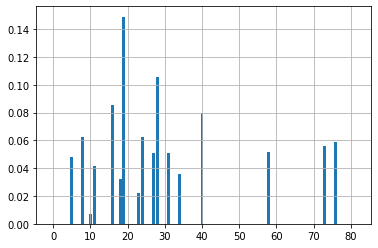

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

model = models['XGB_gs']
plt.bar(
    np.arange(len(model.feature_importances_)),
    model.feature_importances_
)
plt.grid()

pep8(_ih)

# Visualize trainval predictions

In [19]:
models.keys()

dict_keys(['Stacking reg'])

In [23]:
models['Stacking reg'].fit(X_train_val, Y_train_val)

StackingRegressor(estimators=[('RF',
                               RandomForestRegressor(max_depth=1,
                                                     max_features='sqrt',
                                                     n_estimators=2,
                                                     random_state=42)),
                              ('ElasticNet',
                               ElasticNet(alpha=0.05, l1_ratio=0.2,
                                          random_state=42)),
                              ('XGB',
                               GradientBoostingRegressor(max_features='sqrt',
                                                         n_estimators=3,
                                                         random_state=42,
                                                         subsample=0.5))],
                  final_estimator=RandomForestRegressor(max_depth=1,
                                                        n_estimators=3))

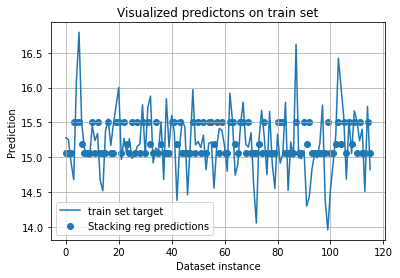

In [25]:
from sklearn_utils import visualize_regression_predictions

visualize_regression_predictions(
    # dict_subset(models, ['RF_rand', 'ElasticNet_rand', 'SVM reg_rand']),
    # dict_subset(models, ['Extra trees_gs', 'Voting reg']),
    models,
    X_=X_train_val[:350],
    Y_=Y_train_val[:350],
    dataset_type_='train set'
)

# Selecting final model

- I select the best model, based on average cross validation score among fine-tuned models. At the same time, i track that this model does not overfit the trainset, and average cross-validation performance is comparable with train metrics

Model             Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
--------------  ----------------------  ----------------  ------------------------  ------------------
RF_gs                        -0.223775         0.0262619                 -0.222786           0.0710622
XGB_gs                       -0.201894         0.0236223                 -0.22042            0.0770356
Extra trees_gs               -0.183293         0.0251006                 -0.21393            0.0779882
Voting reg                   -0.186574         0.021815                  -0.211251           0.0821298
ElasticNet_gs                -0.197008         0.0233346                 -0.210767           0.0788051
SVM reg_gs                   -0.171407         0.0215351                 -0.208325           0.0750395


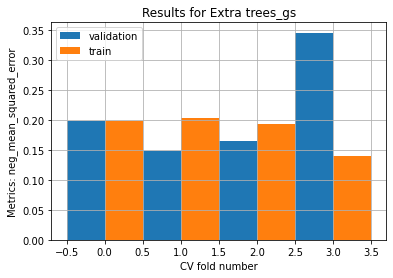

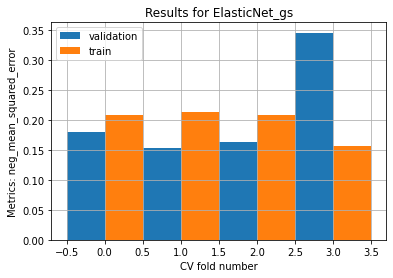

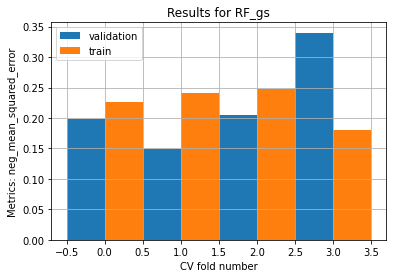

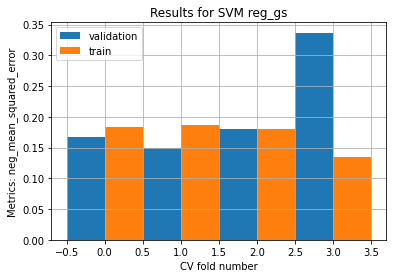

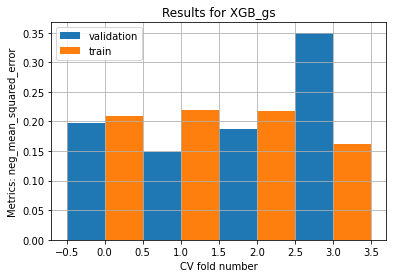

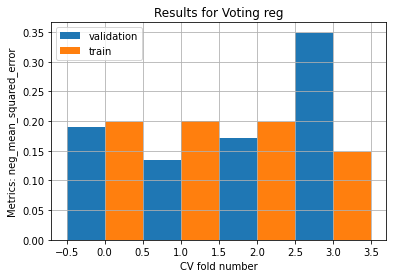

In [ ]:
from sklearn_utils import plot_cv_results

np.random.seed(3)
_ = plot_cv_results(
    models,
    X_=X_train_val,
    Y_=Y_train_val,
    cv_=4,
    scoring_='neg_mean_squared_error',
    to_put_minus_=True
)

In [ ]:
models

{'Extra trees_gs': ExtraTreesRegressor(max_depth=3, max_features='log2', n_estimators=5),
 'ElasticNet_gs': ElasticNet(alpha=0.05, l1_ratio=0.2, random_state=42),
 'RF_gs': RandomForestRegressor(max_depth=1, max_features='sqrt', n_estimators=2,
                       random_state=42),
 'SVM reg_gs': SVR(C=0.2),
 'XGB_gs': GradientBoostingRegressor(max_features='sqrt', n_estimators=3, random_state=42,
                           subsample=0.5),
 'Voting reg': VotingRegressor(estimators=[('XGB',
                              GradientBoostingRegressor(max_features='sqrt',
                                                        n_estimators=3,
                                                        random_state=42,
                                                        subsample=0.5)),
                             ('ElasticNet',
                              ElasticNet(alpha=0.05, l1_ratio=0.2,
                                         random_state=42)),
                             ('Extra

In [ ]:
final_models = {
    'RF_final': models['RF_gs'],
    'XGB_final': models['XGB_gs'],
    'Voting_final': models['Voting reg']
}

In [ ]:
manager.save_models(
    final_models
)